This purpose of this notebook is to plot the t-SNE and AUC-ROC curves for our proposed ensemble approach (both with and without feature selection) on the Dyslexia dataset found in the paper _**"Predicting risk of dyslexia with an online gamified test"**_ by [Rello et al. (2020)](https://doi.org/10.1371/journal.pone.0241687) in order to enhance data interpretability.

# **Library and Dataset Imports**

In [20]:
!pip install -q catboost

try:
    import catboost
    print("catboost imported successfully!")
except ImportError:
    print("catboost not found.")

catboost imported successfully!


In [ ]:
import os
import subprocess

os.environ["CC"] = "/opt/homebrew/Cellar/gcc/14.2.0_1/bin/gcc-14"

result = subprocess.run(["ls", "-la", "/opt/homebrew/Cellar/gcc/14.2.0_1/bin/"], 
                       capture_output=True, text=True)

if "g++-14" in result.stdout:
    os.environ["CXX"] = "/opt/homebrew/Cellar/gcc/14.2.0_1/bin/g++-14"
else:
    print("g++-14 not found in the expected directory!")


%pip install -q --upgrade pymrmr # Library to use mRMR

try:
    import pymrmr
    print("pymrmr imported successfully!")
    print("Version: ", pymrmr.__version__)
except ImportError:
    print("pymrmr not found.")

pymrmr imported successfully!
Version:  0.1.1


In [ ]:
%pip install -q imbalanced-learn # Library for handling imbalanced datasets
%pip install -q seaborn # Library for statistical data visualization
%pip install -q kagglehub # Library for Kaggle datasets
%pip install -q xgboost # Library for XGBoost

try:
    import imblearn
    print("imbalanced-learn imported successfully!")
except ImportError:
    print("imbalanced-learn not found.")

try:
    import seaborn
    print("seaborn imported successfully!")
except ImportError:
    print("seaborn not found.")

try:
    import kagglehub
    print("kagglehub imported successfully!")
except ImportError:
    print("kagglehub not found.")

try:
    import xgboost
    print("xgboost imported successfully!")
except ImportError:
    print("xgboost not found.")


imbalanced-learn imported successfully!
seaborn imported successfully!
kagglehub imported successfully!
xgboost imported successfully!


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pymrmr
from imblearn.over_sampling import ADASYN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [24]:
# Code to update kagglehub (uncomment if needed)
#!pip install --upgrade kagglehub

In [25]:
path = kagglehub.dataset_download("luzrello/dyslexia")

df_desktop = pd.read_csv(path + "/Dyt-desktop.csv", delimiter=';')
df_desktop

,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,...,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
0,Male,No,Yes,7,10,10,0,10,1.0,0.0,...,0,0.000000,0.00,17,2,0,2,0.117647,0.000000,No
1,Female,Yes,Yes,13,12,12,0,12,1.0,0.0,...,4,0.114286,0.00,26,2,2,2,0.076923,0.076923,Yes
2,Female,No,Yes,7,6,6,0,6,1.0,0.0,...,4,0.114286,0.00,26,1,3,1,0.038462,0.115385,No
3,Female,No,Yes,7,0,0,0,0,0.0,0.0,...,0,0.000000,0.00,1,0,0,0,0.000000,0.000000,No
4,Female,No,Yes,8,4,4,0,4,1.0,0.0,...,1,25.000000,0.05,26,2,2,2,0.076923,0.076923,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,Male,No,No,10,7,7,0,7,1.0,0.0,...,2,0.670000,0.33,4,1,3,1,0.250000,0.750000,Yes
3640,Female,No,Yes,15,9,9,0,9,1.0,0.0,...,3,0.750000,0.25,4,2,2,2,0.500000,0.500000,No
3641,Female,No,Yes,15,11,11,0,11,1.0,0.0,...,3,0.600000,0.40,4,2,2,2,0.500000,0.500000,No
3642,Female,No,Yes,15,10,10,0,10,1.0,0.0,...,3,0.750000,0.25,4,3,1,3,0.750000,0.250000,No


In [26]:
df_tablet = pd.read_csv(path + "/Dyt-tablet.csv", delimiter=';')
df_tablet

,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,...,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
0,Male,Yes,No,7,6,6,0,6,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,Female,Yes,No,7,7,7,0,7,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,Female,Yes,No,7,6,6,0,6,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,Male,Yes,No,7,5,5,0,5,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4,Male,Yes,No,7,8,6,2,8,0.75,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,Male,Yes,No,17,13,13,0,13,1.00,0.00,...,35.0,0.114286,0.0,26.0,4.0,0.0,26.0,0.153846,0.000000,No
1391,Female,Yes,Yes,17,9,9,0,9,1.00,0.00,...,35.0,0.114286,0.0,26.0,4.0,0.0,26.0,0.153846,0.000000,No
1392,Male,Yes,Yes,17,10,10,0,10,1.00,0.00,...,35.0,0.114286,0.0,27.0,3.0,2.0,27.0,0.111111,0.074074,No
1393,Female,Yes,Yes,17,11,11,0,11,1.00,0.00,...,35.0,0.114286,0.0,26.0,4.0,0.0,26.0,0.153846,0.000000,No


# **Data Preprocessing and Preparation**

In [45]:
# t-SNE
def plot_tsne(X, y, title):
    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(X)

    label_mapping = {0: "No Dyslexia", 1: "Dyslexia"}
    y_named = [label_mapping[label] for label in y]

    unique_classes = len(set(y))
    palette = sns.color_palette("tab10", unique_classes)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_named, palette=palette, alpha=0.8, edgecolor='black')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(loc='upper right')
    plt.show()

In [28]:
print(df_desktop.info())
print()
print(df_tablet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Columns: 197 entries, Gender to Dyslexia
dtypes: float64(64), int64(129), object(4)
memory usage: 5.5+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Columns: 197 entries, Gender to Dyslexia
dtypes: float64(128), int64(65), object(4)
memory usage: 2.1+ MB
None


In [29]:
print(df_desktop.select_dtypes(include=['number']).describe())
print(df_desktop.select_dtypes(include=['object']).describe())
print()
print("=" * 100)
print()
print(df_tablet.select_dtypes(include=['number']).describe())
print(df_tablet.select_dtypes(include=['object']).describe())

               Age      Clicks1        Hits1      Misses1       Score1  \
count  3644.000000  3644.000000  3644.000000  3644.000000  3644.000000   
mean     10.484907     6.104281     3.683315     0.794731     3.748079   
std       2.478132     4.473068     4.194311     1.191338     4.172533   
min       7.000000     0.000000     0.000000     0.000000     0.000000   
25%       8.750000     3.000000     0.000000     0.000000     0.000000   
50%      10.000000     5.000000     1.000000     0.000000     1.000000   
75%      12.000000     8.000000     7.000000     1.000000     7.000000   
max      17.000000    84.000000    19.000000    18.000000    19.000000   

         Accuracy1    Missrate1      Clicks2        Hits2      Misses2  ...  \
count  3644.000000  3644.000000  3644.000000  3644.000000  3644.000000  ...   
mean      3.047372     4.541253     9.547475     4.844951     0.888310  ...   
std      35.446814    40.329119     5.462742     3.699285     1.829512  ...   
min       0.00000

In [30]:
# Missing values
print(df_desktop.isnull().sum())
print()
print("=" * 100)
print()
print(df_tablet.isnull().sum())

Gender        0
Nativelang    0
Otherlang     0
Age           0
Clicks1       0
             ..
Misses32      0
Score32       0
Accuracy32    0
Missrate32    0
Dyslexia      0
Length: 197, dtype: int64


Gender          0
Nativelang      0
Otherlang       0
Age             0
Clicks1         0
             ... 
Misses32      897
Score32       897
Accuracy32    896
Missrate32    896
Dyslexia        0
Length: 197, dtype: int64


In [ ]:
# Checking the percentage of missing values for each column
missing_percentages = df_desktop.isnull().mean() * 100

# Filtering columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Sorting the results in descending order
missing_percentages = missing_percentages.sort_values(ascending=False)
pd.set_option('display.max_rows', None)

# Displaying the percentages
print(missing_percentages)
pd.reset_option('display.max_rows')

Series([], dtype: float64)


In [ ]:
# Checking the percentage of missing values for each column
missing_percentages = df_tablet.isnull().mean() * 100

# Filtering columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Sorting the results in descending order
missing_percentages = missing_percentages.sort_values(ascending=False)
pd.set_option('display.max_rows', None)

# Displaying the percentages
print(missing_percentages)
pd.reset_option('display.max_rows')

Missrate29    100.000000
Accuracy29    100.000000
Hits29        100.000000
Misses29      100.000000
Score29       100.000000
Clicks29      100.000000
Clicks32       64.301075
Misses31       64.301075
Hits31         64.301075
Clicks31       64.301075
Hits32         64.301075
Misses32       64.301075
Score32        64.301075
Score31        64.301075
Clicks25       64.229391
Misses25       64.229391
Accuracy25     64.229391
Score25        64.229391
Missrate21     64.229391
Hits25         64.229391
Missrate25     64.229391
Score21        64.229391
Accuracy31     64.229391
Missrate31     64.229391
Accuracy32     64.229391
Accuracy21     64.229391
Missrate32     64.229391
Misses21       64.229391
Clicks21       64.229391
Hits21         64.229391
Score28        23.655914
Misses28       23.655914
Hits28         23.655914
Clicks28       23.655914
Clicks20       23.584229
Score27        23.584229
Score20        23.584229
Hits27         23.584229
Clicks27       23.584229
Score26        23.584229


In [ ]:
# Dropping all columns with 100% missing values
df_tablet = df_tablet.dropna(axis=1, how='all')

# Displaying the updated DataFrame
print(df_tablet)

      Gender Nativelang Otherlang  Age  Clicks1  Hits1  Misses1  Score1  \
0       Male        Yes        No    7        6      6        0       6   
1     Female        Yes        No    7        7      7        0       7   
2     Female        Yes        No    7        6      6        0       6   
3       Male        Yes        No    7        5      5        0       5   
4       Male        Yes        No    7        8      6        2       8   
...      ...        ...       ...  ...      ...    ...      ...     ...   
1390    Male        Yes        No   17       13     13        0      13   
1391  Female        Yes       Yes   17        9      9        0       9   
1392    Male        Yes       Yes   17       10     10        0      10   
1393  Female        Yes       Yes   17       11     11        0      11   
1394  Female        Yes        No   17        9      9        0       9   

      Accuracy1  Missrate1  ...  Score31  Accuracy31  Missrate31  Clicks32  \
0          1.00      

In [ ]:
# Checking the percentage of missing values for each column
missing_percentages = df_tablet.isnull().mean() * 100

# Filtering columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Sorting the results in descending order
missing_percentages = missing_percentages.sort_values(ascending=False)
pd.set_option('display.max_rows', None)

# Displaying the percentages
print(missing_percentages)
pd.reset_option('display.max_rows')

Score31       64.301075
Score32       64.301075
Misses32      64.301075
Hits32        64.301075
Clicks32      64.301075
Misses31      64.301075
Hits31        64.301075
Clicks31      64.301075
Hits25        64.229391
Score21       64.229391
Accuracy21    64.229391
Missrate21    64.229391
Clicks25      64.229391
Missrate32    64.229391
Clicks21      64.229391
Misses25      64.229391
Score25       64.229391
Accuracy25    64.229391
Misses21      64.229391
Hits21        64.229391
Missrate25    64.229391
Accuracy32    64.229391
Missrate31    64.229391
Accuracy31    64.229391
Clicks28      23.655914
Hits28        23.655914
Misses28      23.655914
Score28       23.655914
Score26       23.584229
Hits26        23.584229
Misses26      23.584229
Score24       23.584229
Misses24      23.584229
Hits24        23.584229
Clicks24      23.584229
Misses20      23.584229
Score20       23.584229
Clicks27      23.584229
Hits27        23.584229
Misses27      23.584229
Score27       23.584229
Clicks20      23

Desktop Target Distribution:
Dyslexia
No     89.242591
Yes    10.757409
Name: proportion, dtype: float64


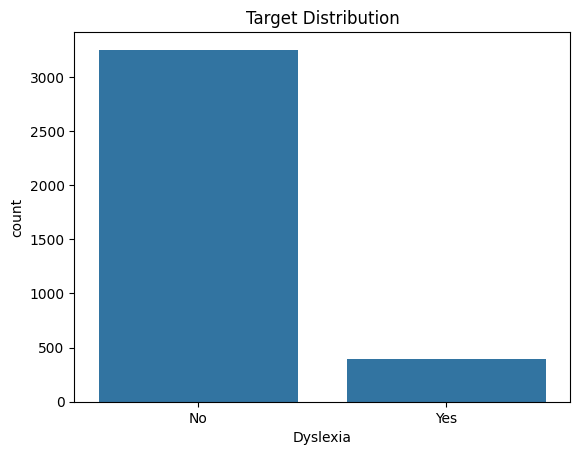


Tablet Target Distribution:
Dyslexia
No     89.390681
Yes    10.609319
Name: proportion, dtype: float64


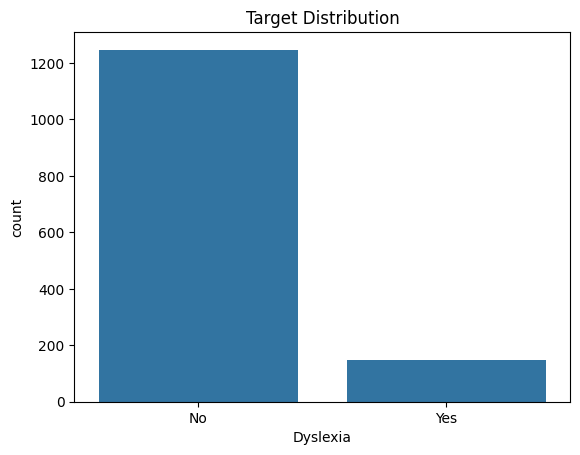

In [ ]:
# Checking output label imbalance
target_column = "Dyslexia"

print("Desktop Target Distribution:")
print(f"{df_desktop[target_column].value_counts(normalize=True) * 100}")
sns.countplot(x=df_desktop[target_column])
plt.title("Target Distribution")
plt.show()
print()
print("Tablet Target Distribution:")
print(f"{df_tablet[target_column].value_counts(normalize=True) * 100}")
sns.countplot(x=df_tablet[target_column])
plt.title("Target Distribution")
plt.show()

Clearly, there is a huge imbalance in the positive and negative classes.

Stratified KFold to be used.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encoding categorical columns in df_desktop
categorical_cols = df_desktop.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    df_desktop[col] = le.fit_transform(df_desktop[col])
df_desktop

Encoding column: Gender
Encoding column: Nativelang
Encoding column: Otherlang
Encoding column: Dyslexia


,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,...,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
0,1,0,1,7,10,10,0,10,1.0,0.0,...,0,0.000000,0.00,17,2,0,2,0.117647,0.000000,0
1,0,1,1,13,12,12,0,12,1.0,0.0,...,4,0.114286,0.00,26,2,2,2,0.076923,0.076923,1
2,0,0,1,7,6,6,0,6,1.0,0.0,...,4,0.114286,0.00,26,1,3,1,0.038462,0.115385,0
3,0,0,1,7,0,0,0,0,0.0,0.0,...,0,0.000000,0.00,1,0,0,0,0.000000,0.000000,0
4,0,0,1,8,4,4,0,4,1.0,0.0,...,1,25.000000,0.05,26,2,2,2,0.076923,0.076923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,1,0,0,10,7,7,0,7,1.0,0.0,...,2,0.670000,0.33,4,1,3,1,0.250000,0.750000,1
3640,0,0,1,15,9,9,0,9,1.0,0.0,...,3,0.750000,0.25,4,2,2,2,0.500000,0.500000,0
3641,0,0,1,15,11,11,0,11,1.0,0.0,...,3,0.600000,0.40,4,2,2,2,0.500000,0.500000,0
3642,0,0,1,15,10,10,0,10,1.0,0.0,...,3,0.750000,0.25,4,3,1,3,0.750000,0.250000,0


In [ ]:
# Finding duplicate samples
duplicates = df_desktop.duplicated().sum()
print(f"Number of Duplicate Samples: {duplicates}")
if duplicates > 0:
    print("Dropping Duplicates...")
    df_desktop.drop_duplicates(inplace=True)
    print("Duplicates Dropped.")
else:
    print("No Duplicate Samples Found.")

Number of Duplicate Samples: 0
No Duplicate Samples Found.


In [ ]:
X = df_desktop.drop("Dyslexia",axis=1) # Input features
y = df_desktop['Dyslexia'] # Target variable

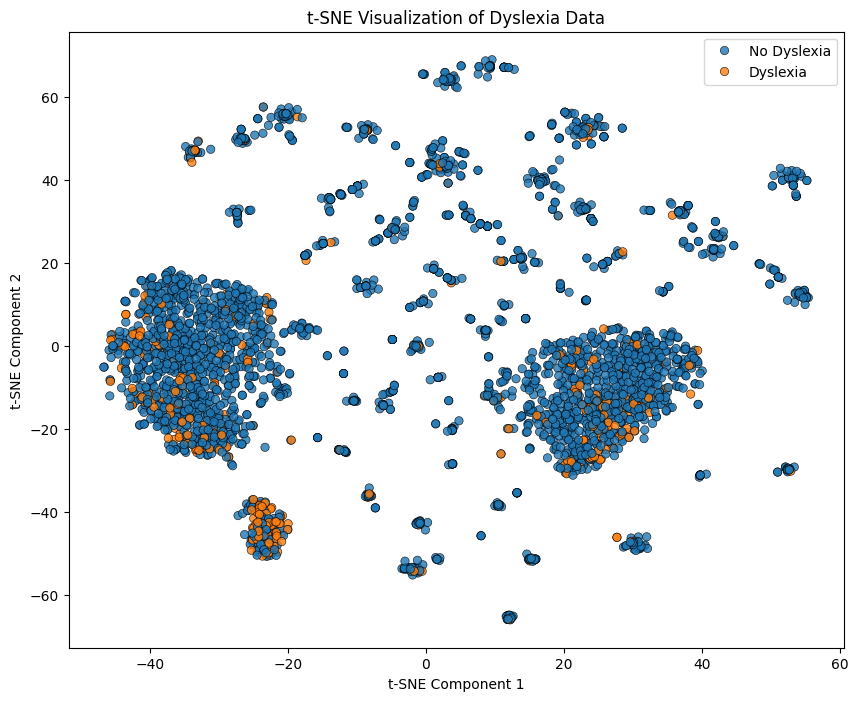

In [46]:
# t-SNE
plot_tsne(X, y, "t-SNE Visualization of Dyslexia Data")

# **Self-Model Implementation**

In [ ]:
classes, samples_in_class = np.unique(y, return_counts=True) # Number of samples in each class
n_classes = len(classes) # Number of classes
total_samples = len(y) # Total number of samples
class_weights = [total_samples / (n_classes * count) for count in samples_in_class] # Class weights for each class based on the number of samples in each class
class_weights_dict = {i: class_weights[i] for i in range(n_classes)} # Dictionary to store class weights

negative_samples = samples_in_class[0]  # Count of class 0 (No Dyslexia)
positive_samples = samples_in_class[1]  # Count of class 1 (Dyslexia)

scale_pos_weight = negative_samples / positive_samples # Scale positive weight for imbalanced classes

### **Ensemble Model Baseline**

In [ ]:
# Creating a Stratified K-Fold cross-validation object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Dictionaries to store model predictions and true labels
predictions_soft = {}
true_labels_soft = {}

# Lists to store all true labels, predictions, and probabilities for soft voting
all_y_true = []
all_y_pred = []
all_y_proba = []

# Start of k-fold cross-validation loop
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print(f"🧪 Fold {fold}", end = " ")
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :] # k-fold input data
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # k-fold output data

    # Ensemble model structure
    models = [
        ('xgb', XGBClassifier(verbosity=0, scale_pos_weight=scale_pos_weight, random_state=42)),
        ('bg', BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'), random_state=42)),
        ('gbc', HistGradientBoostingClassifier(class_weight=class_weights_dict, random_state=42)),
        ('cat', CatBoostClassifier(verbose=0, class_weights = class_weights, random_state=42)),
    ]
    weights = [1.0] * len(models) # Weights for each model's predictions in determing the final prediction

    # Creating a soft-voting classifier object
    soft_voting = VotingClassifier(estimators=models, voting='soft', weights=weights)
    soft_voting.fit(X_train, y_train) # Training

    soft_preds = soft_voting.predict(X_test) # Testing (with predictions)
    soft_probs = soft_voting.predict_proba(X_test) # Testing (with probabilities)

    # Storing predictions and true labels for the current fold
    predictions_soft[fold] = soft_preds
    true_labels_soft[fold] = y_test.values

    # Storing all true labels, predictions, and probabilities for the current fold
    all_y_true.extend(y_test)
    all_y_pred.extend(soft_preds)
    all_y_proba.extend(soft_probs)

# Calculating overall metrics for the soft-voting ensemble
acc_soft = accuracy_score(all_y_true, all_y_pred)
precision_soft = precision_score(all_y_true, all_y_pred, average='weighted')
recall_soft = recall_score(all_y_true, all_y_pred, average='weighted')
f1_soft  = f1_score(all_y_true, all_y_pred, average='weighted')

print(f"\n🔵 Overall Soft Voting Accuracy (165 features): {acc_soft:.4f}")
print(f"🔵 Overall Soft Voting Precision (165 features): {precision_soft:.4f}")
print(f"🔵 Overall Soft Voting Recall (165 features): {recall_soft:.4f}")
print(f"🟣 Overall Soft Voting F1-score (165 features): {f1_soft:.4f}")

🧪 Fold 1 🧪 Fold 2 🧪 Fold 3 🧪 Fold 4 🧪 Fold 5 🧪 Fold 6 🧪 Fold 7 🧪 Fold 8 🧪 Fold 9 🧪 Fold 10 
🔵 Overall Soft Voting Accuracy (165 features): 0.9138
🔵 Overall Soft Voting Precision (165 features): 0.9028
🔵 Overall Soft Voting Recall (165 features): 0.9138
🟣 Overall Soft Voting F1-score (165 features): 0.9048


In [ ]:
# Ensemble's predictions confusion matrix
cm_aggregated_ensemble = confusion_matrix(all_y_true, all_y_pred)
print(f"Soft-Voting Ensemble Confusion Matrix:\n", cm_aggregated_ensemble)
print("\n")

# Calculating class-wise metrics
classes = np.unique(y)  # List of unique class labels

for i, class_label in enumerate(classes):
    TP = cm_aggregated_ensemble[i, i]  # True positives for class i
    FP = cm_aggregated_ensemble[:, i].sum() - TP  # False positives for class i
    FN = cm_aggregated_ensemble[i, :].sum() - TP  # False negatives for class i

    # Calculating precision, recall, and F1 score for each class
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Printing the metrics for each class
    print(f"Class {class_label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 40)

Soft-Voting Ensemble Confusion Matrix:
 [[3169   83]
 [ 231  161]]


Class 0:
  Precision: 0.9321
  Recall: 0.9745
  F1 Score: 0.9528
----------------------------------------
Class 1:
  Precision: 0.6598
  Recall: 0.4107
  F1 Score: 0.5063
----------------------------------------


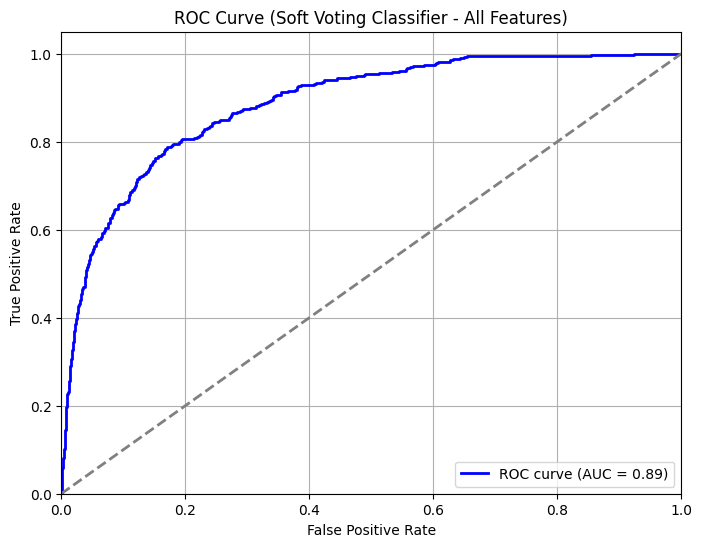

In [ ]:
# AUC-ROC Curve
all_y_proba = np.array(all_y_proba)
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting the curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Soft Voting Classifier - All Features)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## **mRMR + Ensemble (Uniform Weights)**



 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 167 	 Clicks28 	 0.054
2 	 143 	 Clicks24 	 0.054
3 	 149 	 Clicks25 	 0.051
4 	 2 	 Nativelang 	 0.047
5 	 185 	 Clicks31 	 0.043
6 	 161 	 Clicks27 	 0.039
7 	 152 	 Score25 	 0.035
8 	 150 	 Hits25 	 0.035
9 	 119 	 Clicks20 	 0.032
10 	 191 	 Clicks32 	 0.030
11 	 168 	 Hits28 	 0.030
12 	 170 	 Score28 	 0.029
13 	 173 	 Clicks29 	 0.025
14 	 144 	 Hits24 	 0.025
15 	 146 	 Score24 	 0.025
16 	 131 	 Clicks22 	 0.021
17 	 113 	 Clicks19 	 0.021
18 	 134 	 Score22 	 0.021


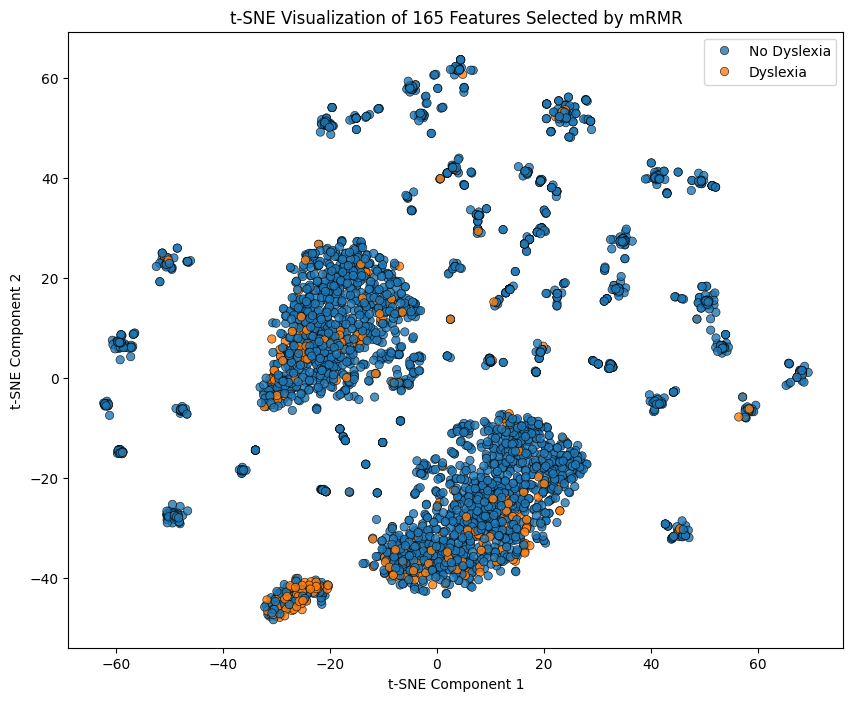

In [48]:
# t-SNE of 165 features
data_165 = pd.concat([y, X], axis=1)
data_165.columns = data_165.columns.astype(str)
selected_features = pymrmr.mRMR(data_165, 'MIQ', 165)
X_selected = X[selected_features]

plot_tsne(X_selected, y, "t-SNE Visualization of 165 Features Selected by mRMR")

### **Soft-Voting Ensemble using 165 Features**

In [ ]:
num_features = 165 # Optimal number of features based on previous analysis

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # Creating StratifiedKFold object for cross-validation

predictions_soft = {} # Dictionary to store model predictions
true_labels_soft = {} # Dictionary to store true labels

# Lists to store all true labels, predictions, and probabilities for soft voting
all_y_true = []
all_y_pred = []
all_y_score = []

# Start of k-fold cross-validation loop
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print(f"🧪 Fold {fold}", end = " ")
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :] # k-fold input data
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # k-fold output data

    # Creating a DataFrame for mRMR (mRMR requires a DataFrame with the target variable as the first column)
    data_train = pd.concat([
        pd.DataFrame({'target': y_train}).reset_index(drop=True),
        X_train.reset_index(drop=True)
    ], axis=1)
    data_train.columns = data_train.columns.astype(str)

    selected_features = pymrmr.mRMR(data_train, 'MIQ', num_features) # Applying mRMR to select features

    # Choosing the top features based on mRMR
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    # Ensemble model structure
    models = [
        ('xgb', XGBClassifier(verbosity=0, scale_pos_weight=scale_pos_weight, random_state=42)),
        ('bg', BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'), random_state=42)),
        ('gbc', HistGradientBoostingClassifier(class_weight=class_weights_dict, random_state=42)),
        ('cat', CatBoostClassifier(verbose=0, class_weights = class_weights, random_state=42)),
    ]
    weights = [1.0] * len(models) # Weights for each model's predictions in determining the final prediction

    # Creating a soft-voting classifier object
    soft_voting = VotingClassifier(estimators=models, voting='soft', weights=weights)
    soft_voting.fit(X_train_sel, y_train) # Training

    soft_preds = soft_voting.predict(X_test_sel) # Testing (with predictions)
    soft_probs = soft_voting.predict_proba(X_test_sel) # Testing (with probabilities)

    # Storing predictions and true labels for the current fold
    predictions_soft[fold] = soft_preds
    true_labels_soft[fold] = y_test.values

    # Storing all true labels, predictions, and probabilities for the current fold
    all_y_true.extend(y_test)
    all_y_pred.extend(soft_preds)
    all_y_score.extend(soft_probs)

# Calculating overall metrics for the soft-voting ensemble
acc_soft = accuracy_score(all_y_true, all_y_pred)
precision_soft = precision_score(all_y_true, all_y_pred, average='weighted')
recall_soft = recall_score(all_y_true, all_y_pred, average='weighted')
f1_soft  = f1_score(all_y_true, all_y_pred, average='weighted')

print(f"\n🔵 Overall Soft Voting Accuracy (165 features): {acc_soft:.4f}")
print(f"🔵 Overall Soft Voting Precision (165 features): {precision_soft:.4f}")
print(f"🔵 Overall Soft Voting Recall (165 features): {recall_soft:.4f}")
print(f"🟣 Overall Soft Voting F1-score (165 features): {f1_soft:.4f}")

🧪 Fold 1 

 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 167 	 Clicks28 	 0.054
2 	 149 	 Clicks25 	 0.054
3 	 143 	 Clicks24 	 0.054
4 	 2 	 Nativelang 	 0.048
5 	 185 	 Clicks31 	 0.045
6 	 161 	 Clicks27 	 0.040
7 	 152 	 Score25 	 0.037
8 	 150 	 Hits25 	 0.037
9 	 119 	 Clicks20 	 0.034
10 	 168 	 Hits28 	 0.030
11 	 191 	 Clicks32 	 0.030
12 	 170 	 Score28 	 0.029
13 	 173 	 Clicks29 	 0.025
14 	 146 	 Score24 	 0.024
15 	 144 	 Hits24 	 0.024
16 	 134 	 Score22 	 0.022
17 	 132 	 Hits22 	 0.022
18 	 163 	 Misses27 	

In [ ]:
# Ensemble's predictions confusion matrix
cm_aggregated_ensemble_mrmr = confusion_matrix(all_y_true, all_y_pred)
print(f"Soft-Voting Ensemble (mRMR) Confusion Matrix:\n", cm_aggregated_ensemble_mrmr)
print("\n")

# Calculating class-wise metrics
classes = np.unique(y)  # List of unique class labels

for i, class_label in enumerate(classes):
    TP = cm_aggregated_ensemble_mrmr[i, i]  # True positives for class i
    FP = cm_aggregated_ensemble_mrmr[:, i].sum() - TP  # False positives for class i
    FN = cm_aggregated_ensemble_mrmr[i, :].sum() - TP  # False negatives for class i

    # Calculating precision, recall, and F1 score for each class
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Printing the metrics for each class
    print(f"Class {class_label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 40)

Soft-Voting Ensemble (mRMR) Confusion Matrix:
 [[3167   85]
 [ 229  163]]


Class 0:
  Precision: 0.9326
  Recall: 0.9739
  F1 Score: 0.9528
----------------------------------------
Class 1:
  Precision: 0.6573
  Recall: 0.4158
  F1 Score: 0.5094
----------------------------------------


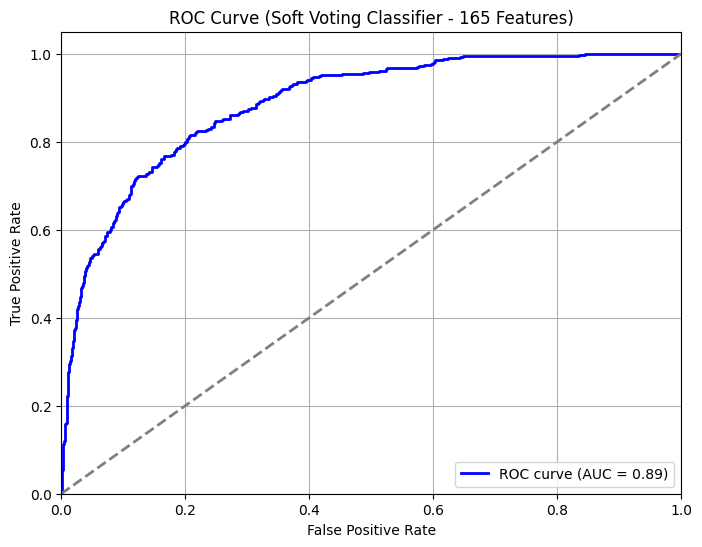

In [ ]:
# AUC-ROC Curve for 165 features
all_y_score = np.array(all_y_score)
fpr_165, tpr_165, thresholds = roc_curve(all_y_true, all_y_score[:, 1])
roc_auc_165 = auc(fpr, tpr)

# Plotting the curve for 165 features
plt.figure(figsize=(8, 6))
plt.plot(fpr_165, tpr_165, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_165:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Soft Voting Classifier - 165 Features)')
plt.legend(loc='lower right')
plt.grid()
plt.show()